## Lifespan analysis of BW-derived traits

### Load preamble

In [1]:
from __future__ import absolute_import
from __future__ import print_function

import warnings
warnings.filterwarnings("ignore")

from IPython.core.display import display, HTML
display(HTML("<style>.container { width:100% !important; }</style>"))

%config Completer.use_jedi = False

%load_ext autoreload
%autoreload 2

In [2]:
import os
import sys
import argparse
import pickle
import pandas as pd
import numpy as np
from functools import partial

import seaborn as sns
import matplotlib.pyplot as plt
from matplotlib.lines import Line2D
import matplotlib.patches as mpatches
import matplotlib.gridspec as gridspec
from matplotlib.ticker import FormatStrFormatter
plt.rcParams["font.family"] = "Arial"

os.chdir("../")
sys.path.append(os.getcwd())

In [3]:
def save_figure(fdir, fname):

  # save figure
  ftypes = ['.pdf']
  os.makedirs(fdir, exist_ok=True)
  for ftype in ftypes:
    plt.savefig(os.path.join(fdir, fname + ftype),
                bbox_inches='tight',
                dpi=300)
  return

### Load data

In [4]:
TVCPH_MODEL_DIR = "data/tvcph"
MODEL_TYPE = "tvcph"

### CPH of time interval traits

In [5]:
def plot_tvcph(mode="timeint",
               model_dir=TVCPH_MODEL_DIR,
               model_type="tvcph",
               weighted=False,
               transform=False,
               phenotype="state_occupancy",
               events=None,
               legend_pos=None,
               legend_title=None,
               legend_pos2=None,
               frame_title=None,
               save=False,
               fname=None):

  # states
  state_names = ['DS', 'SS', 'GS']
  full_state_names = {"DS": "Decline",
                      "SS": "Steady",
                      "GS": "Growth"}

  # events
  if (phenotype in ['state_transitions', 'max_abs_growthrate',\
                    'max_abs_growthrate_percent']) and (events is not None):
    snames = state_names
    state_names = events
  if (phenotype == 'resilience') and (events is not None):
    state_names = events

  # diets
  diets = ["AL", "1D", "2D", "20", "40"]
  diet_colors = ['red', 'blue', 'green', 'darkorchid', 'darkorange']

  # min and max age in days
  min_age_days = 30
  max_age_days = 1260
  interval = 180

  # time inervals
  time_intervals = [t1 for t1 in np.arange(0,
                                           max_age_days + 1,
                                           interval)]

  # interventions
  interventions = ["pre", "post"]

  # figure properties
  fig, ax = plt.subplots(figsize=(25/3, 3.5), nrows=1, ncols=1)
  sns.set(font_scale=0.95)
  sns.set_style("white")
  sns.set_context("talk")
  markers = ['o', 's', 'D']
  xshift = [-0.15, 0.0, 0.15]

  if mode == "timeint":
    posx = np.arange(0, len(time_intervals[:-1]))
  elif mode == "prepost":
    posx = np.arange(0, len(interventions))

  # for every state name
  for s, state_name in enumerate(state_names):

    # get feature names
    cnames = []

    # if mode is timeint
    if mode == "timeint":
      for t, ti in enumerate(time_intervals[:-1]):
        if phenotype != 'state_transitions':
          name = phenotype.replace('_', '.') + '.' + \
                  str(time_intervals[t]) + '.to.' + str(time_intervals[t+1]) + \
                  '.' + state_names[s]
        elif (phenotype == 'state_transitions') and (events is not None):
          sname = state_name.split('.')
          name = phenotype.replace('_', '.') + '.' + \
                  str(time_intervals[t]) + '.to.' + str(time_intervals[t+1]) + \
                  '.' + sname[0] + '.' + sname[1]
        cnames.append(name)

    # if mode is prepost
    elif mode == "prepost":
      for i, inter in enumerate(interventions):
        if phenotype != 'state_transitions':
          name = inter + '.' + phenotype.replace('_', '.') + '.' + state_names[s]
        elif (phenotype == 'state_transitions') and (events is not None):
          sname = state_name.split('.')
          name = inter + '.' + phenotype.replace('_', '.') + '.' + sname[0] + '.' + sname[1]
        cnames.append(name)

    elif mode == "resilience":
      cnames = ["resilience" + "." + state_name]

    if weighted and (phenotype in ['avg_bodyweight', 'avg_growthrate',
                                   'max_bodyweight', 'min_bodyweight',
                                   'max_growthrate', 'min_growthrate',
                                   'max_abs_growthrate', 'state_occupancy',
                                   'state_transitions', 'max_abs_growthrate_percent']):
      cnames = ["weighted." + c for c in cnames]

    all_es = []
    for c, cname in enumerate(cnames):

      cached_csvname = os.path.join(model_dir, cname+'.csv')
      df_params = pd.read_csv(cached_csvname, sep=',', index_col=['param', 'covariate'])
      if (model_type == 'cph') or (model_type == 'tvcph'):
        es = df_params.loc[('coef', 'phenotype'), cname]
        se = df_params.loc[('se(coef)', 'phenotype'), cname]
        pval = df_params.loc[('p', 'phenotype'), cname]
        if es > 0:
          color='red'
        else:
          color = 'blue'
        if np.abs(es) > 1000:
          es = np.nan
          se = np.nan

        if pval < 0.05:
          ax.errorbar(x=posx[c]+xshift[s],
                      y=es,
                      yerr=se,
                      marker=markers[s],
                      ms=12,
                      mfc=color,
                      ecolor="black",
                      capsize=3,
                      mec="black")
        else:
          ax.errorbar(x=posx[c]+xshift[s],
                      y=es,
                      yerr=se,
                      marker=markers[s],
                      ms=12,
                      mfc='white',
                      ecolor="black",
                      capsize=3,
                      mec="black")

        all_es.append(es)

    # add vertical line at x = 0
    ax.plot(posx+xshift[s], np.array(all_es), color='black', linewidth=1)
    ax.plot([0, posx[c]], [0, 0], linestyle='dotted', color='gray', linewidth=2)
    ax.plot([0, 0], [0, 0], color='black', linewidth=2)

  ax.spines['right'].set_visible(False)
  ax.spines['top'].set_visible(False)
  ax.spines['left'].set_visible(True)
  ax.spines['bottom'].set_visible(True)
  ax.tick_params(axis='x', which='major', bottom=True, labelsize=16)
  ax.tick_params(axis='y', which='major', left=True, labelsize=16)

  if mode == "timeint":
    xticklabels = ['[' + str(time_intervals[t] // 30) + ', ' + \
                    str(time_intervals[t+1] // 30) + ')'\
                    for t, _ in enumerate(time_intervals[:-1])]
  elif mode == "prepost":
    xticklabels = interventions
  elif mode == "resilience":
    xticklabels = [state_name]

  xticks = posx
  ax.set_xticks(xticks)
  ax.set_xticklabels(xticklabels, rotation=30)
  ax.set_xlabel("months", fontsize=20)
  ax.set_ylabel("$\log(PH)$", fontsize=20)
  ax.yaxis.set_major_formatter(FormatStrFormatter('%.2f'))
  ax.set_title(frame_title, fontsize=20, weight="bold")

  labels = []
  for s, state_name in enumerate(state_names):
    if (phenotype not in ['state_transitions', 'resilience']):
      labels.append(full_state_names[state_name])

    elif phenotype == 'state_transitions':
      sn = state_name.split('.')
      labels.append(full_state_names[sn[1]] + ' to ' + full_state_names[sn[0]])
    else:
      labels.append(state_name)
    ax.errorbar(x= [], y =[], yerr = [], marker=markers[s], mfc='white',
                ecolor='black', capsize=3, mec="black",
                label=labels[s], color='k', ms=12)
  if legend_pos is None:
    legend_pos = (0.00, 1.05, 0.5, 0.5)
  ax.legend(frameon=False, ncol=1, fontsize=16,
            bbox_to_anchor=legend_pos, title=legend_title)


  ax2 = ax.twinx()
  ax2.get_yaxis().set_visible(False)
  mfc_colors = ["black", "white"]
  sig_labels = [r'$ p \leq 0.05 $', r'$ p > 0.05 $']
  for m, mfc_color in enumerate(mfc_colors):
    ax2.errorbar(x=[],
                  y=[],
                  yerr=[],
                  label=sig_labels[m],
                  ms=12,
                  marker='p',
                  capsize=3,
                  color="black",
                  mec="black",
                  mfc=mfc_color)

  if legend_pos2 is None:
    legend_pos2 = (0.15, 1.05, 0.5, 0.5)

  ax2.legend(frameon=False,
             fontsize=16,
             bbox_to_anchor=legend_pos2)
  ax2.spines['right'].set_visible(False)
  ax2.spines['top'].set_visible(False)
  ax2.spines['left'].set_visible(True)
  ax2.spines['bottom'].set_visible(True)


  plt.subplots_adjust(hspace=0.25)
  fig.align_labels()

  # save figure
  if save and (fname is not None):
    save_figure(fdir="images",
                fname=fname)

  plt.show()
  return

#### State occupancy

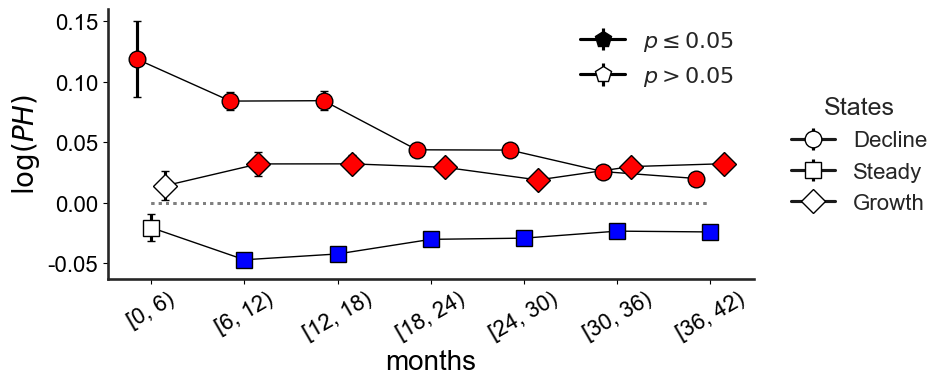

In [6]:
plot_tvcph(mode="timeint",
           weighted=True,
           transform=False,
           phenotype="state_occupancy",
           events=None,
           legend_pos=(1.05, 0.25, 0.25, 0.5),
           legend_title="States",
           legend_pos2=(0.30, 0.50, 0.70, 0.5),
           save=False,
           fname='ls_state_occupancy')

#### State transitions

##### To steady state

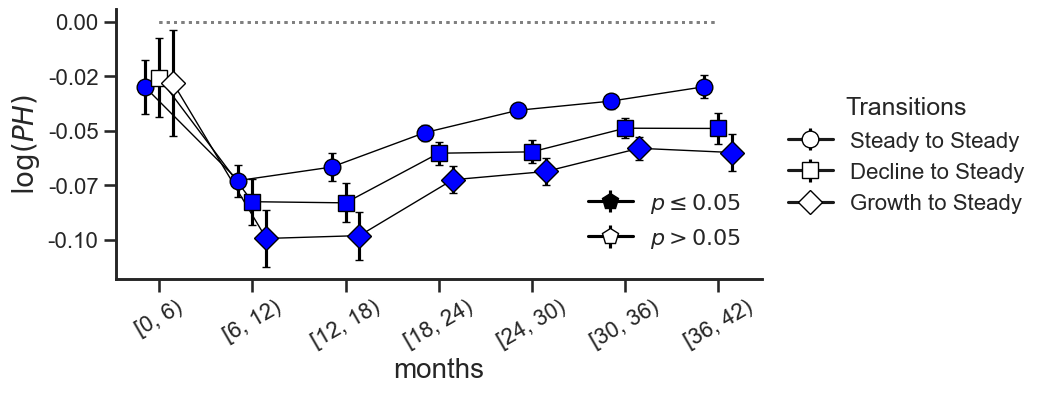

In [7]:
plot_tvcph(mode="timeint",
           weighted=True,
           transform=False,
           phenotype="state_transitions",
           events=['SS.SS', 'SS.DS', 'SS.GS'],
           legend_pos=(1.01, 0.25, 0.25, 0.5),
           legend_title="Transitions",
           legend_pos2=(0.30, -0.10, 0.70, 0.5),
           save=False,
           fname='ls_state_transitions_to_steady')

##### To decline state

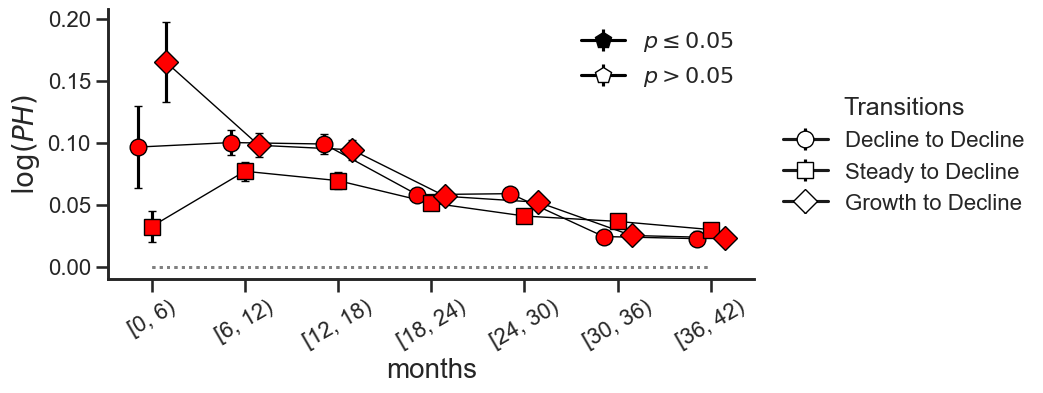

In [8]:
plot_tvcph(mode="timeint",
           weighted=True,
           transform=False,
           phenotype="state_transitions",
           events=['DS.DS', 'DS.SS', 'DS.GS'],
           legend_pos=(1.20, 0.25, 0.25, 0.5),
           legend_title="Transitions",
           legend_pos2=(0.30, 0.5, 0.70, 0.5),
           save=False,
           fname='ls_state_transitions_to_decline')

##### To growth state

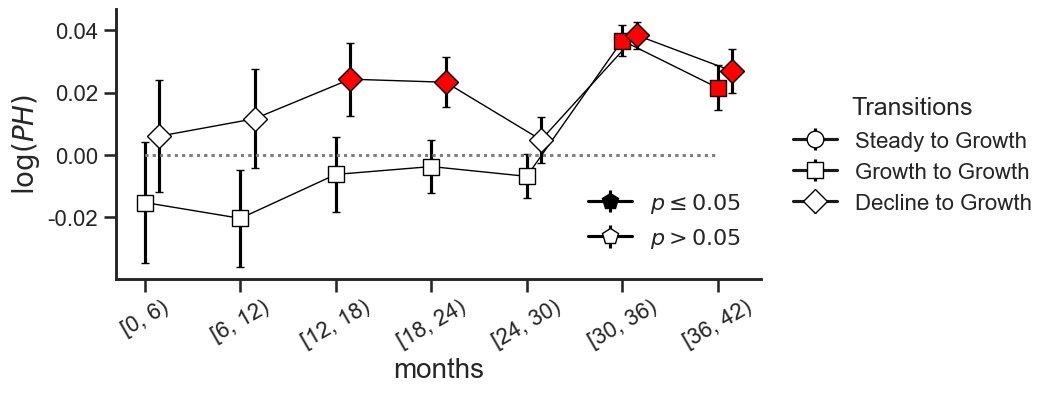

In [9]:
plot_tvcph(mode="timeint",
           weighted=True,
           transform=False,
           phenotype="state_transitions",
           events=['GS.SS', 'GS.GS', 'GS.DS'],
           legend_pos=(1.20, 0.25, 0.25, 0.5),
           legend_title="Transitions",
           legend_pos2=(0.30, -0.10, 0.70, 0.5),
           save=False,
           fname='ls_state_transitions_to_growth')

### CPH of pre-post traits

In [10]:
def tall_plot_coxph(phenotype_list,
                    prepost="post",
                    model_dir=TVCPH_MODEL_DIR,
                    legend_pos2=None,
                    save=False,
                    fname=None):

  state_names = ['DS', 'SS', 'GS']
  full_state_names = ["decline", "steady", "growth"]
  phenotype_names = {
      'state_occupancy': "state occupancy",
      'state_transitions': "state transitions",
      'longest_bout': "longest bout",
      'start_time_longest_bout': "start time of the longest bout",
      'max_abs_growthrate': "max absolute rate",
      'max_abs_growthrate_percent': "normalized max absolute rate"
  }

  # figure properties
  fig, ax = plt.subplots(figsize=(25/3, 18), nrows=1, ncols=1)
  sns.set(font_scale=0.95)
  sns.set_style("white")
  sns.set_context("talk")
  posy = 3*np.arange(0, len(phenotype_list))

  es = []
  se = []
  pval = []
  yticklabels = []

  for p, params in enumerate(phenotype_list):

    phenotype = params[0]
    mode = params[1]
    weighted = params[2]
    event = params[5]

    cname = prepost + '.' + phenotype.replace('_', '.') + '.' + event
    if weighted:
      cname = 'weighted.' + cname

    cached_csvname = os.path.join(model_dir, cname+'.csv')
    df_params = pd.read_csv(cached_csvname, sep=',', index_col=['param', 'covariate'])
    es.append(df_params.loc[('coef', 'phenotype'), cname])
    se.append(df_params.loc[('se(coef)', 'phenotype'), cname])
    pval.append(df_params.loc[('p', 'phenotype'), cname])

    if phenotype != 'state_transitions':
      txt = phenotype_names[phenotype] + "\n" + "in " + \
      full_state_names[state_names.index(event)] + " state"
    else:
      txt = phenotype_names[phenotype] + " from " + "\n" + \
            full_state_names[state_names.index(event.split('.')[1])] + ' to ' + \
            full_state_names[state_names.index(event.split('.')[0])] + " state"
    yticklabels.append(txt)

  order = np.argsort(es)
  yticklabels = [yticklabels[o] for o in order]
  for i, o in enumerate(order):

    if pval[o] < 0.05:
      if es[o] > 0:
        ax.errorbar(x=es[o],
                    y=posy[i],
                    xerr=se[o],
                    marker='o',
                    ms=10,
                    mfc="red",
                    ecolor="black",
                    capsize=3,
                    mec='black')
      else:
        ax.errorbar(x=es[o],
                    y=posy[i],
                    xerr=se[o],
                    marker='o',
                    ms=10,
                    mfc="blue",
                    ecolor="black",
                    capsize=3,
                    mec='black')
    else:
      ax.errorbar(x=es[o],
                  y=posy[i],
                  yerr=se[o],
                  marker='o',
                  ms=10,
                  mfc='white',
                  ecolor="black",
                  # color=color,
                  capsize=3,
                  mec="black")

    ax.annotate(f'$p = ${pval[o]:.1e}', (es[o], posy[i]-1.25),
                fontsize=14, ha='center')

  ax.axvline(x=0, ls='dotted', color="gray", linewidth=2)
  ax.spines['right'].set_visible(False)
  ax.spines['top'].set_visible(False)
  ax.spines['left'].set_visible(True)
  ax.spines['bottom'].set_visible(True)
  ax.tick_params(axis='x', which='major', bottom=True, labelsize=18)
  ax.tick_params(axis='y', which='major', left=True, labelsize=18)
  ax.set_xticks(np.linspace(-0.1, 0.4, 6))
  ax.set_xlim([-0.1, 0.4])
  ax.set_yticks(posy)
  ax.set_yticklabels(yticklabels, fontsize=16)
  ax.set_xlabel("$\log(PH)$", fontsize=20)

  ax2 = ax.twinx()
  ax2.get_yaxis().set_visible(False)
  mfc_colors = ["black", "white"]
  sig_labels = [r'$ p \leq 0.05 $', r'$ p > 0.05 $']
  for m, mfc_color in enumerate(mfc_colors):
    ax2.errorbar(x=[],
                  y=[],
                  yerr=[],
                  label=sig_labels[m],
                  ms=10,
                  marker='o',
                  capsize=3,
                  color="black",
                  mec="black",
                  mfc=mfc_color)

  if legend_pos2 is None:
    legend_pos2 = (0.45, 0.5, 0.5, 0.5)

  ax2.legend(frameon=False,
             fontsize=16,
             bbox_to_anchor=legend_pos2)
  ax2.spines['right'].set_visible(False)
  ax2.spines['top'].set_visible(False)
  ax2.spines['left'].set_visible(True)
  ax2.spines['bottom'].set_visible(True)

  # save figure
  if save and (fname is not None):
    save_figure(fdir='figure5',
                fname=fname)

  return

In [11]:
phenotype_list = [
    ['state_occupancy', 'prepost', True, "rankint", False, 'DS'],
    ['state_occupancy', 'prepost', True, "rankint", False, 'SS'],
    ['state_occupancy', 'prepost', True, "rankint", False, 'GS'],
    ['state_transitions', 'prepost', True, "rankint", False, 'DS.DS'],
    ['state_transitions', 'prepost', True, "rankint", False, 'SS.DS'],
    ['state_transitions', 'prepost', True, "rankint", False, 'GS.DS'],
    ['state_transitions', 'prepost', True, "rankint", False, 'DS.SS'],
    ['state_transitions', 'prepost', True, "rankint", False, 'SS.SS'],
    ['state_transitions', 'prepost', True, "rankint", False, 'DS.GS'],
    ['state_transitions', 'prepost', True, "rankint", False, 'SS.GS'],
    ['state_transitions', 'prepost', True, "rankint", False, 'GS.GS'],
    ['longest_bout', 'prepost', False, "rankint", False, 'DS'],
    ['longest_bout', 'prepost', False, "rankint", False, 'SS'],
    ['longest_bout', 'prepost', False, "rankint", False, 'GS'],
    ['start_time_longest_bout', 'prepost', False, "rankint", False, 'DS'],
    ['start_time_longest_bout', 'prepost', False, "rankint", False, 'SS'],
    ['start_time_longest_bout', 'prepost', False, "rankint", False, 'GS'],
    ['max_abs_growthrate', 'prepost', True, "rankint", False, 'DS'],
    ['max_abs_growthrate', 'prepost', True, "rankint", False, 'GS'],
]

#### Pre-intervention

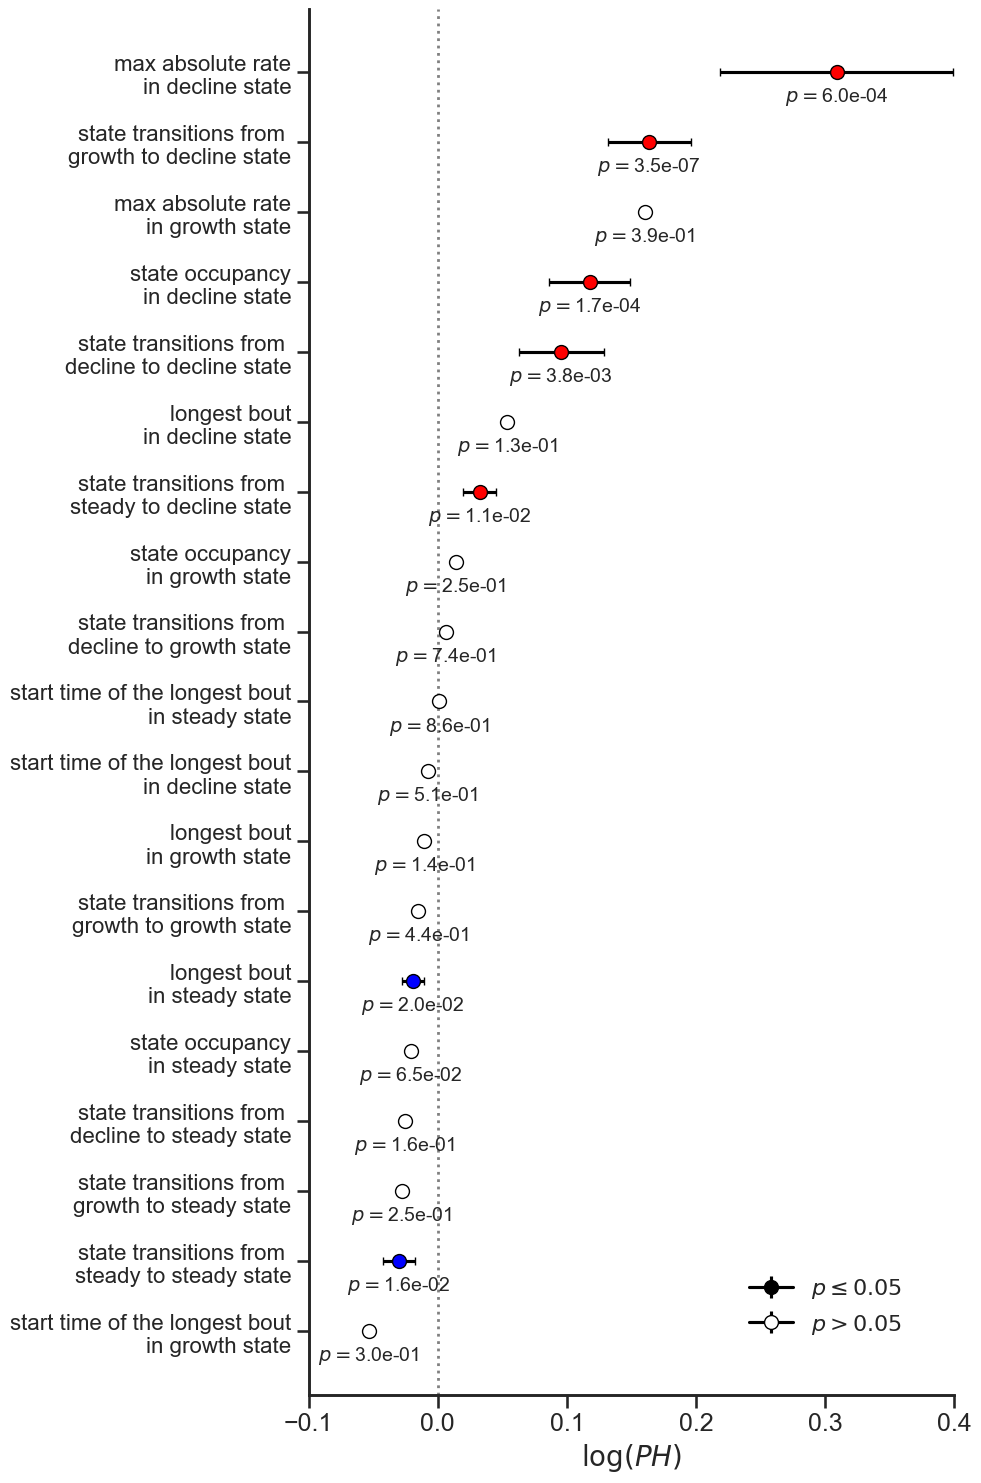

In [12]:
tall_plot_coxph(phenotype_list,
                prepost="pre",
                legend_pos2=(0.45, -0.4, 0.5, 0.5),
                save=False,
                fname="tvch_post_all_phenotypes")

#### Post-intervention

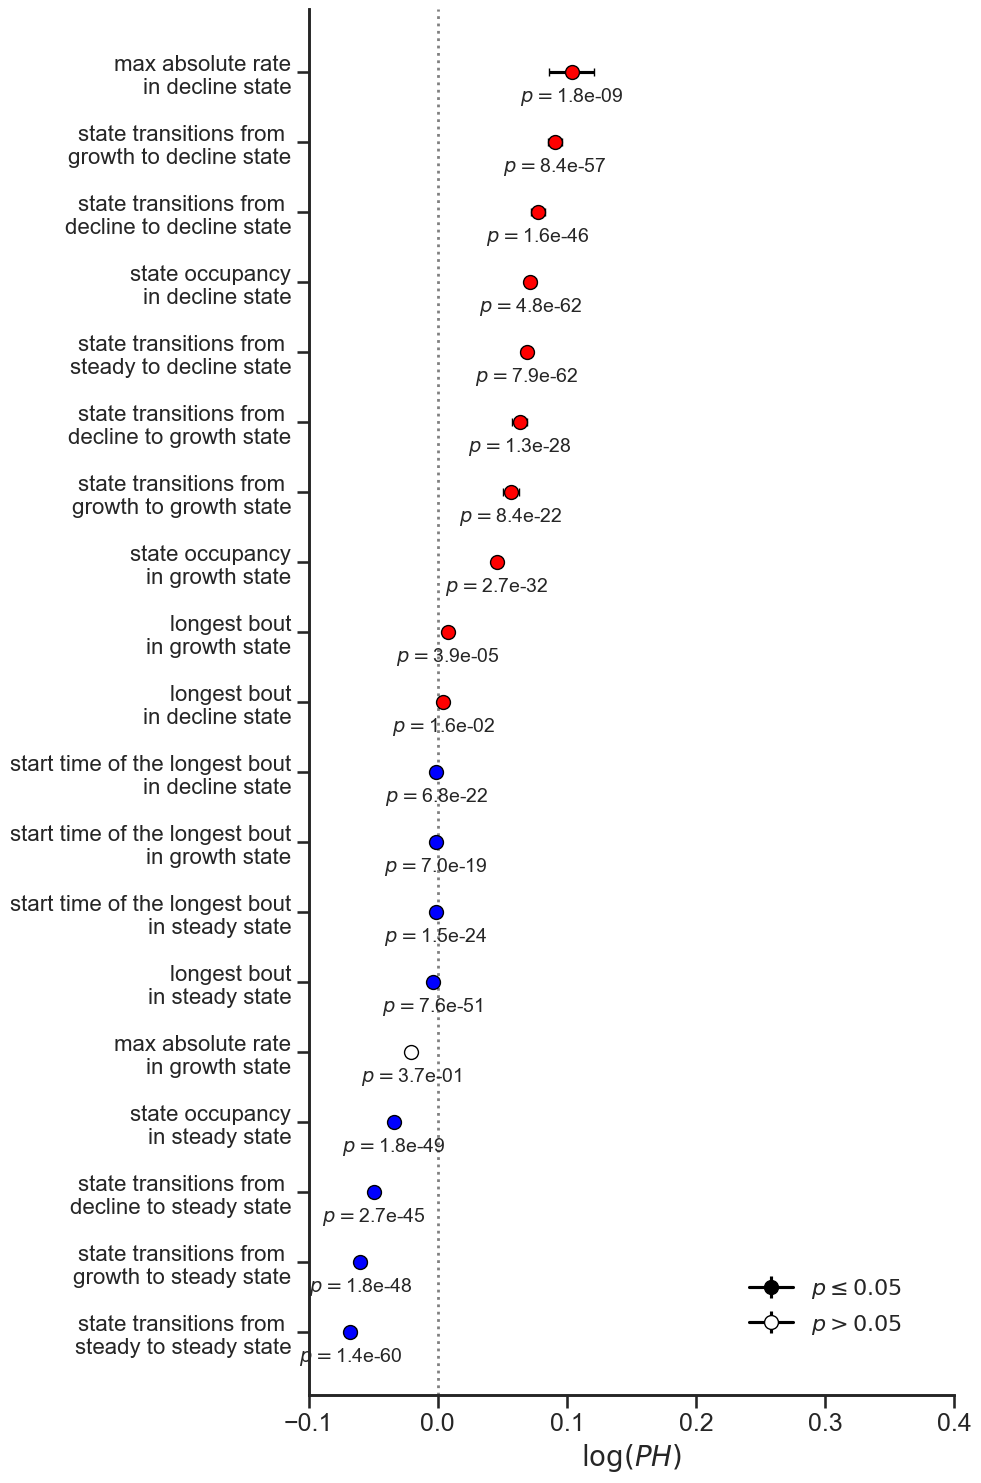

In [13]:
tall_plot_coxph(phenotype_list,
                prepost="post",
                legend_pos2=(0.45, -0.4, 0.5, 0.5),
                save=False,
                fname="tvch_post_all_phenotypes")

### CPH of adaptation to stress

In [14]:
def resilience_plot(mode="resilience",
                    model_type="tvcph",
                    model_dir=TVCPH_MODEL_DIR,
                    phenotype="resilience.mean",
                    save=False,
                    fname=None):

  event_dict = {
                'FA':'facs',
                'AC':'acoustic.startle',
                'HO':'homecage.wheel',
                'FR':'frailty',
                'CB':'cbc',
                'ME':'metcage',
                'EC':'ecg'
                # 'PI':'pixi',
                # 'RO':'rotarod',
                # 'GR':'grip',
                }

  age_bin_interest = [[180, 1600]]
  yshift = [0]
  posy = np.arange(0, len(list(event_dict.keys())))
  linestyle = ['solid', 'dotted']
  markers = ['o', 's', 'D']

  fig = plt.figure(figsize=(12, 4))
  ax = plt.subplot(1, 1, 1)
  sns.set(font_scale=0.95)
  sns.set_style("white")
  sns.set_context("talk")

  for a, age_bin in enumerate(age_bin_interest):
    for e, event in enumerate(list(event_dict.keys())):

      cname = phenotype +'.' + event + '.' + str(age_bin[0])\
                + '.to.' + str(age_bin[1])
      cached_csvname = os.path.join(model_dir, cname+'.csv')

      df_params = pd.read_csv(cached_csvname, sep=',', index_col=['param', 'covariate'])
      if (model_type == 'cph') or (model_type == 'tvcph'):
        es = df_params.loc[('coef', 'phenotype'), cname]
        se = df_params.loc[('se(coef)', 'phenotype'), cname]
        pval = df_params.loc[('p', 'phenotype'), cname]
        if es > 0:
          color='red'
        else:
          color = 'blue'
        if pval < 0.05:

          ebar = ax.errorbar(x=posy[e]+yshift[a],
                              y=es,
                              yerr=se,
                              marker=markers[a],
                              mfc=color,
                              ms=10,
                              ecolor="black",
                              # color=color,
                              capsize=3,
                              mec=color)
        else:
          ebar = ax.errorbar(x=posy[e]+yshift[a],
                              y=es,
                              yerr=se,
                              marker=markers[a],
                              ms=10,
                              mfc='white',
                              ecolor="black",
                              # color=color,
                              capsize=3,
                              mec="black")
        ax.annotate(f'$p = ${pval:.1e}', (posy[e]+yshift[a]+0.15, es-0.1),
                    fontsize=14, ha='center', rotation=90)

  ax.spines['right'].set_visible(False)
  ax.spines['top'].set_visible(False)
  ax.spines['left'].set_visible(True)
  ax.spines['bottom'].set_visible(True)

  ax.plot([posy[0]+yshift[0], posy[-1]+yshift[-1]], [0, 0], linestyle='--', color='gray')

  yticklabels = []
  for e, event in enumerate(event_dict.keys()):
    cname = phenotype + '.' + event_dict[event]
    tmp = event_dict[event].split('.')
    label = tmp[0].title()
    if label in ['Pixi', 'Facs', 'Ecg', 'Cbc']:
      label = label.upper()
    yticklabels.append(label)

  ax.set_xticks(posy)
  ax.set_xticklabels(yticklabels, fontsize=20, rotation=45)
  ax.set_ylabel("$\log(PH)$", fontsize=20)

  # save figure
  if save and (fname is not None):
    save_figure(fdir='figure5',
                fname=fname)

  plt.show()
  return

#### Adapation to stress (average)

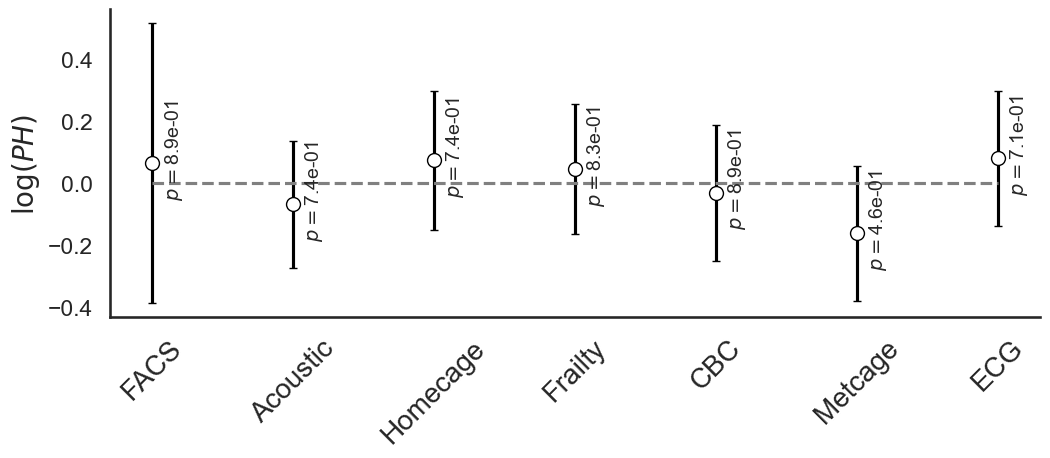

In [15]:
resilience_plot(mode="resilience",
                phenotype="resilience.mean",
                save=False,
                fname="ls_resilience")